In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Data Description

### Players Dataset 
The dataset located in `players.csv` contains information about each player and their experience with Minecraft.
It contains fields:
- `experience <fct>` - Experience level with minecraft, from "Beginner" to "Pro"
- `subscribe <lgl>` - Whether a player has subscribed to a game-related newsletter
- `hashedEmail<chr>` - The players's hashed email – should be unique per player so it can be used as a key to compare between datasets. 
- `played_hours<dbl>` - Time played on the PLAICraft server (hours)
- `name<chr>` - First name
- `gender<fct>` - Gender – The dataset contains 7 unique values for gender
- `Age<dbl>` - Age (years)

*Note: These may not be the data types that r origonally loads with the read_csv method but instead are the ones that best describe the data*

The dataset has 196 rows and 7 variables.
There is a clumping of players with 0 hours played that could cause issues for certain classification models where too much importance is assigned to fitting this point.
Additionally, two NA values in the age column may cause issues and should be filtered out.

### Sessions Dataset
The dataset located in `sessions.csv` contains information about players' invidiaul sessions on the Mincraft server.
It contains fields:
- `hashedEmail<chr>` same as `hashedEmail` from the players dataset
- `start_time<chr>` - the start time of the session in DD/MM/YYYY HH:mm format
- `end_time<chr>` the end time of the session in DD/MM/YYYY HH:mm format
- `original_start_time<dbl>` the session's start time in UNIX time
- `original_end_time<dbl>` the session's end time in UNIX time

This dataset contains 1535 rows with NA's in columns `end_time` and `origonal_end_time` that could cause errors and may need to be filtered out.

## Research Question
Broad Question: 

*What player characteristics ... differ between various player types?*

Specific question:

*What variables in a tuned nearest-neighbors model best predict whether a player is subscribed to the game-related-newsletter?*

I will wrangle my data from the players dataset by ensuring that all NA's are dropped and all columns are the correct type - like ensuring `experience` is transformed to a numerical value signifying experience level. Finally, I will center and scale all  predictors before training my KNN model.

## Explore Data and Visualization

In [3]:
# Load Data
session_df <- read_csv('sessions.csv')
players_df <- read_csv('players.csv') 

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# Mean Values
players_df |>
    select(where(is.numeric)) |>
    map_df(mean, na.rm = TRUE)

played_hours,Age
<dbl>,<dbl>
5.845918,20.52062


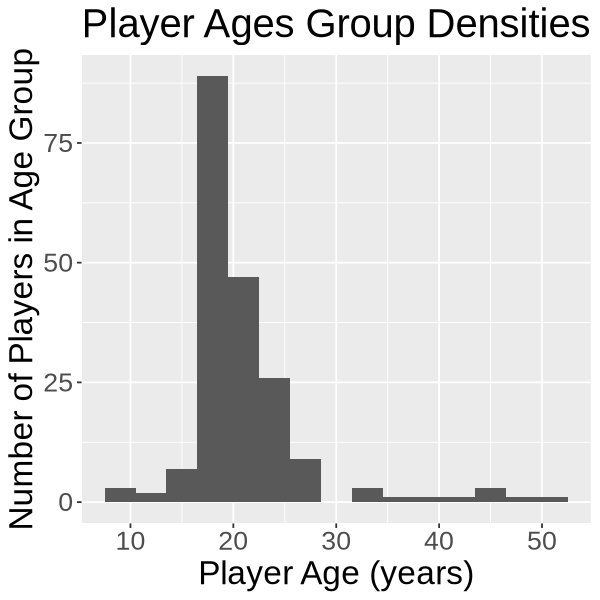

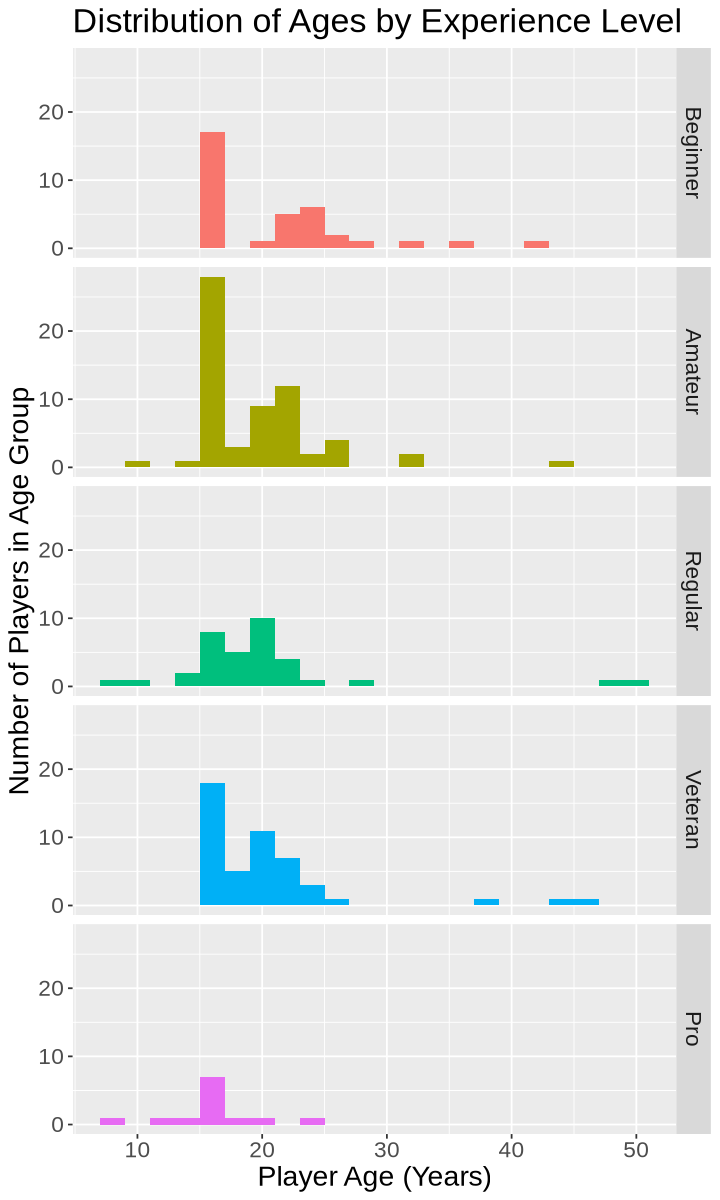

In [11]:
# Visualizations

# Remove NA's and add levels to experience for visualization
players_df <- players_df |>
    filter(!is.na(Age)) |>
    mutate("experience" = factor(
        experience, 
        levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"), 
        )
    )

# Histogram of ages in the players dataset
# Shows us that that most players are younger - around 17 to 25
options(repr.plot.width = 5, repr.plot.height = 5)
players_df |>
    ggplot(aes(x = Age)) +
        geom_histogram(binwidth = 3) + 
        labs(
            x = "Player Age (years)",
            y = "Number of Players in Age Group"
        ) +
        ggtitle("Player Ages Group Densities") +
        theme(text = element_text(size = 20))


# Compare Age to Game Experience
# It appears that age has little affect on experience level at the game
options(repr.plot.width = 6, repr.plot.height = 10)
players_df |> 
    ggplot(aes(x = Age, fill = experience)) +
    geom_histogram(binwidth = 2) + 
    facet_grid(rows = vars(experience)) + 
    labs(
        x = "Player Age (Years)",
        y = "Number of Players in Age Group",
        fill = "Experience Level"
    ) + 
    ggtitle("Distribution of Ages by Experience Level") + 
    theme(text = element_text(size = 17), legend.position = "none")


## Methods and Plan
I will train a series of K-nearest-neighbors models to perform binary classfication on the `subscribe` variable from the players dataset. Each of these models will select a different subset of the columns to use as predictors. Only numerical columns will be candidates for predictors. Each model will be tuned to have the highest accuracy on the training set (75% of totaldata) via v-fold-cross-validation. I will infer that the model with the highest training accuracy best represents the data, thus the variables it used as predictors are most predictive of whether a player is subscribed to the newsletter.
This method answers my question by testing the KNN model with multiple sets of variables and finding which variables are most effective. We assume that non-numerical variables (like name and hash) are not predictive of newsletter subscription.